BBB Project Part 2
===

- Shows performance of bayes by backprop, a method using Variational Inference on a network

In [1]:
# Add local folders to path
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [2]:
from collections import OrderedDict

import pymc3 as pm
import theano
import theano.tensor as tt

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import mode
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

%matplotlib inline

In [3]:
print('PyMC3  v{}\nTheano v{}'.format(pm.__version__,theano.__version__))

PyMC3  v3.5
Theano v1.0.3


In [4]:
# Set random seeds
np.random.seed(42)
pm.set_tt_rng(42)

In [5]:
# Avoid warnings on batches below
from warnings import filterwarnings
filterwarnings('ignore')

In [6]:
# Use tensorflow to import image datasets
import tensorflow as tf

reshape_train_imgs = lambda img : img.reshape(img.shape[0],-1)
imgvec2img = lambda vec : vec.reshape((np.sqrt(vec.shape[0]).astype(int),np.sqrt(vec.shape[0]).astype(int)))
floatX = theano.config.floatX

dataset = 'fashion_mnist'

if dataset == 'mnist':
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train,X_test = reshape_train_imgs(X_train),reshape_train_imgs(X_test)
    label_dict = OrderedDict({i:str(i) for i in range(10)})
    
    X_train = X_train.astype(floatX)/255
    y_train = y_train.astype(np.int)
    X_test = X_test.astype(floatX)/255
    y_test = y_test.astype(np.int)
    
    n_output = len(label_dict)
    
elif dataset == 'fashion_mnist':
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    X_train,X_test = reshape_train_imgs(X_train),reshape_train_imgs(X_test)
    label_dict = OrderedDict({0: 'T-shirt/top',
                              1: 'Trouser',
                              2: 'Pullover',
                              3: 'Dress',
                              4: 'Coat',
                              5: 'Sandal',
                              6: 'Shirt',
                              7: 'Sneaker',
                              8: 'Bag',
                              9: 'Ankle boot'})
    X_train = X_train.astype(floatX)/255
    y_train = y_train.astype(np.int)
    X_test = X_test.astype(floatX)/255
    y_test = y_test.astype(np.int)
    
    n_output = len(label_dict)

(n_train,n_input) = X_train.shape
print("N Input for {} = {}".format(dataset,n_input))

N Input for fashion_mnist = 784


Use `%load` magic here to load `bbb_nn.py`. Delete are re-run a cell as below for updates:
```python
%load bbb_nn.py
```

In [7]:
# %load bbb_nn.py
def construct_nn(ann_input, ann_output, n_input, n_output, n_train, n_hidden_1=64, n_hidden_2=32):
    # backwards compatibility
    return construct_nn_2lay(ann_input, ann_output, n_input, n_output, n_train, n_hidden_1, n_hidden_2)

def construct_nn_1lay(ann_input, ann_output, n_input, n_output, n_train, n_hidden_1=64):
    
    # Initialize random weights between each layer
    init_w_in_1 = np.random.randn(n_input, n_hidden_1).astype(theano.config.floatX)
    init_b_1 = np.random.randn(n_hidden_1).astype(theano.config.floatX)
    init_w_1_out = np.random.randn(n_hidden_1, n_output).astype(theano.config.floatX)
    
    with pm.Model() as neural_network:
        # Weights from input to first hidden layer
        w_in_1 = pm.Normal('w_in_1', mu=0, sd=0.5, shape=(n_input, n_hidden_1), testval=init_w_in_1)
        
        # Bias in first layer
        b_1 = pm.Normal('b_1',mu=0, sd=0.5, shape=(n_hidden_1), testval=init_b_1)
        
        # Weights from 1st hidden layer to output layer
        w_1_out = pm.Normal('w_1_out',mu=0, sd=0.5, shape=(n_hidden_1, n_output), testval=init_w_1_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.Deterministic('act_1',var=pm.math.tanh(pm.math.dot(ann_input,w_in_1)+b_1))        
        
        # Softmax is required at last layer
        act_out = pm.Deterministic('act_out',var=tt.nnet.softmax(pm.math.dot(act_1,w_1_out)))
        
        # Classification
        out = pm.Categorical('out',act_out,observed=ann_output,total_size=n_train)
        
    return neural_network

def construct_nn_2lay(ann_input, ann_output, n_input, n_output, n_train, n_hidden_1=64, n_hidden_2=32):
    
    # Initialize random weights between each layer
    init_w_1 = np.random.randn(n_input, n_hidden_1).astype(theano.config.floatX)
    init_w_2 = np.random.randn(n_hidden_1, n_hidden_2).astype(theano.config.floatX)
    init_out = np.random.randn(n_hidden_2, n_output).astype(theano.config.floatX)
    
    # Initialize bias for each layer  
    
    # did I ADd the bias wrong?
    init_b_1 = np.random.randn(n_hidden_1).astype(theano.config.floatX)
    init_b_2 = np.random.randn(n_hidden_2).astype(theano.config.floatX)
    
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        w_0_1 = pm.Normal('w_0_1', mu=0, sd=0.15, shape=(n_input, n_hidden_1), testval=init_w_1)
        # Bias from in first layer
        b_1 = pm.Normal('b_1',mu=0, sd=0.15, shape=(n_hidden_1), testval=init_b_1)
        
        # Weights from 1st to 2nd layer
        w_1_2 = pm.Normal('w_1_2',mu=0, sd=0.15, shape=(n_hidden_1, n_hidden_2), testval=init_w_2)
        # Bias from in first layer
        b_2 = pm.Normal('b_2', mu=0, sd=0.15, shape=(n_hidden_2), testval=init_b_2)
        
        # Weights from hidden layer to output
        w_2_out = pm.Normal('w_2_out', mu=0, sd=0.15,shape=(n_hidden_2,n_output),testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.Deterministic('act_1',var=pm.math.tanh(pm.math.dot(ann_input,w_0_1)+b_1))
        act_2 = pm.Deterministic('act_2',var=pm.math.tanh(pm.math.dot(act_1,w_1_2)+b_2))
        
        # Softmax is required at last layer
        act_out = pm.Deterministic('act_out',var=tt.nnet.softmax(pm.math.dot(act_2,w_2_out)))
        
        # Classification
        out = pm.Categorical('out',act_out,observed=ann_output,total_size=n_train)
        
    return neural_network

In [8]:
# We selected number of nodes/layers for fast performance
n_hidden = 96
net_name = "Layer1: {}nodes".format(n_hidden)

minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(y_train, batch_size=50)

(n_train,n_input) = X_train.shape
NN_model = construct_nn_1lay(minibatch_x, minibatch_y, n_input, n_output, n_train, n_hidden_1=n_hidden)

NN_model.name = net_name
print(NN_model.name)

Layer1: 96nodes


In [9]:
# convergence not great, use a different method for conv check after:
# https://docs.pymc.io/notebooks/variational_api_quickstart.html
with NN_model:
    advi = pm.ADVI()
    
# After the bayes by BackProp paper!
print(advi.approx.shared_params)

# To better look at convergence, we keep track of parameter mean and std
ev_mean = advi.approx.mean.eval # callable that returns mean
ev_std = advi.approx.std.eval # callable that returns std
tracker = pm.callbacks.Tracker(mean=ev_mean,std=ev_std)
print(tracker.whatchdict)

n_approx_iter = 20000
with NN_model:
    approx = advi.fit(n=n_approx_iter, callbacks=[tracker])
    # callbacks do not work for large numbers of iters on the network (>40k)
    #approx = advi.fit(n=n_approx_iter)

{'mu': mu, 'rho': rho}
{'mean': <bound method Variable.eval of mu>, 'std': <bound method Variable.eval of softplus.0>}


Average Loss = 235.09: 100%|██████████| 20000/20000 [03:54<00:00, 78.48it/s]
Finished [100%]: Average Loss = 235.21


In [10]:
# a reshape on a random subset might be more efficient here
#tracker_means = np.array(tracker['mean'][randset])
get_weight_mean = lambda i : [t[i] for t in tracker['mean']]
get_weight_stds = lambda i : [t[i] for t in tracker['std']]

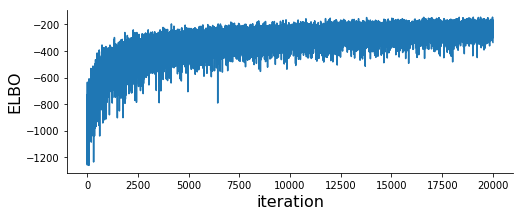

In [11]:
# plotting the training progress
elbo_1 = -advi.hist

figsize = (8,3); fontsize = 16;
f, ax = plt.subplots(1,1,figsize=figsize);

ax.plot(elbo_1,label='1')
ax.set_ylabel('ELBO',fontsize=fontsize)
ax.set_xlabel('iteration',fontsize=fontsize);
sns.despine();

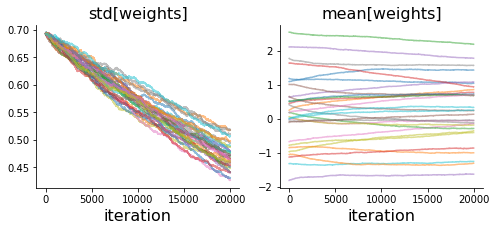

In [12]:
figsize = (8,3); fontsize = 16;
f, axs = plt.subplots(1,2,figsize=figsize)

ax = axs[0]
for i in range(30):
    ax.plot(get_weight_stds(i),alpha=0.5,label=i)
ax.set_xlabel('iteration',fontsize=fontsize);
ax.set_title('std[weights]',fontsize=fontsize);
sns.despine();

ax = axs[1]
for i in range(30):
    ax.plot(get_weight_mean(i),alpha=0.5,label=i)
ax.set_xlabel('iteration',fontsize=fontsize);
ax.set_title('mean[weights]',fontsize=fontsize);
sns.despine();

Average Loss = 170.7: 100%|██████████| 20000/20000 [03:55<00:00, 88.54it/s]
Finished [100%]: Average Loss = 170.7


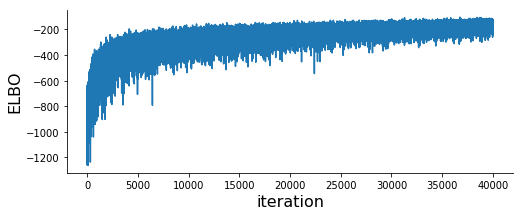

In [13]:
# Run for a few more samples if desired
run_again = True
if run_again:
    advi.refine(n=20000);
    elbo_2 = -advi.hist
    
    figsize = (8,3); fontsize = 16;
    f, ax = plt.subplots(1,1,figsize=figsize);
    ax.plot(elbo_2,label='elbo_2');
    ax.set_ylabel('ELBO',fontsize=fontsize);
    ax.set_xlabel('iteration',fontsize=fontsize);
    sns.despine();

In [14]:
# Draw samples from variational posterior (the weights in the network)
n_draws = 1000 # > 2k hangs for almost all network sizes on my 2018 MBP -SH
trace = approx.sample(draws=n_draws)

### Look at training set performance

In [15]:
# network at performance on the training set
(n_train,n_input) = X_train.shape
train_x = theano.shared(X_train)
train_y = theano.shared(y_train)
NN_model_train = construct_nn_1lay(train_x, train_y, n_input, n_output, n_train, n_hidden_1=n_hidden)
with NN_model_train:
    ppc_train = pm.sample_ppc(trace, samples=100)

100%|██████████| 100/100 [03:48<00:00,  2.23s/it]


In [16]:
# Prediction is mode of each
train_y_pred = mode(ppc_train['out'], axis=0).mode[0,:]

mean_train_perf = np.mean(train_y_pred==y_train)
print("Network Training Set Performance: {:f}".format(mean_train_perf))

Network Training Set Performance: 0.824550


### Look at test set performance

In [17]:
# network at performance on the test set
(n_test,n_input) = X_test.shape
test_x = theano.shared(X_test)
test_y = theano.shared(y_test)
NN_model_test = construct_nn_1lay(test_x, test_y, n_input, n_output, n_test, n_hidden_1=n_hidden)
with NN_model_test:
    ppc_test = pm.sample_ppc(trace, samples=100)
    #ppc_test = pm.sample_posterior_predictive(trace, samples=100)

100%|██████████| 100/100 [00:41<00:00,  2.56it/s]


In [18]:
# dims: [n_samples] x [n_test_set]
ppc_test['out'].shape

(100, 10000)

In [19]:
ncol = ppc_test['out'].shape[0]
nrow = ppc_test['out'].shape[1]
nhot = n_output
onehot = np.zeros(shape=(ncol,nrow,nhot))
for i in range(ncol):
    onehot[i][np.arange(n_test), ppc_test['out'][i]] = 1

In [20]:
# Prediction is mode of each
test_y_pred = mode(ppc_test['out'], axis=0).mode[0,:]

mean_test_perf = np.mean(test_y_pred==y_test)
print("Network Test Set Performance: {:f}".format(mean_test_perf))

Network Test Set Performance: 0.813600


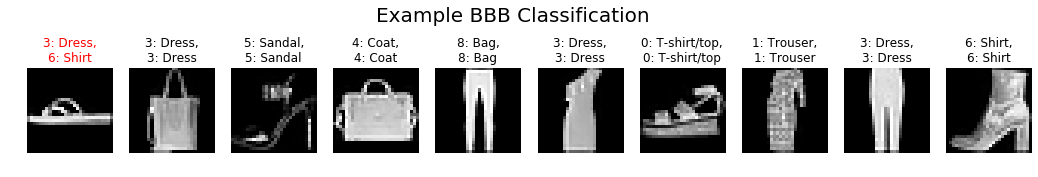

In [21]:
# PLot random subset of images
n_plot_samples = 10
rand_samps = np.random.choice(X_test.shape[0],size=n_plot_samples)

figsize = (18,3); fontsize = 16;
f, axs = plt.subplots(1, n_plot_samples, figsize=figsize);

for rs,ax in zip(rand_samps,axs):
    ax.imshow(imgvec2img(X_train[rs]),cmap='gray');
    tl = "{}: {},\n{}: {}".format(test_y_pred[rs],label_dict[test_y_pred[rs]],y_test[rs],label_dict[y_test[rs]])
    if test_y_pred[rs] == y_test[rs]:
        ax.set_title(tl,color='k');
    else:
        ax.set_title(tl,color='r');
    ax.axis('off');
    sns.despine();
    
f.suptitle("Example BBB Classification",fontsize=fontsize+4);